In [1]:
import numpy as np
import pandas as pd

import sklearn

import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('dark_background')

from tensorflow import keras

## Read Dataset 

In [3]:
import tensorflow_datasets

In [4]:
from sklearn.datasets import load_digits

digits = load_digits()
print(digits.data.shape)

(1797, 64)


In [5]:
digits.images.shape

(1797, 8, 8)

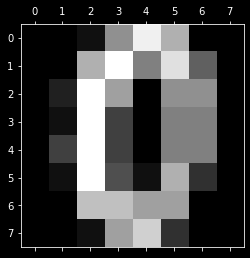

In [7]:
plt.matshow(digits.images[10], cmap='gray')
plt.show()

In [11]:
pd.DataFrame(digits.data).min().min()

0.0

## Normalizing features to [0, 1] (sklearn)

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
digits_norm = scaler.fit_transform(digits.data)

## Reducing Dimensions using PCA (sklearn)

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
digits_nd = pca.fit_transform(digits_norm)

pca.explained_variance_ratio_

array([0.14815157, 0.13523675, 0.11706654, 0.08316524, 0.05736613,
       0.04850088, 0.04252878, 0.0367751 , 0.03323319, 0.03046623])

In [17]:
np.sum(pca.explained_variance_ratio_)

0.7324904148189966

## Clustering using k-Means (sklearn)

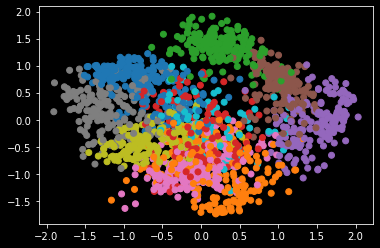

In [18]:
from sklearn.cluster import KMeans

clustering = KMeans(n_clusters=10).fit(digits.data)

# Visualize Result
cmap = plt.get_cmap('tab10')

plt.scatter(digits_nd[:, 0], digits_nd[:, 1], c=cmap(clustering.labels_))

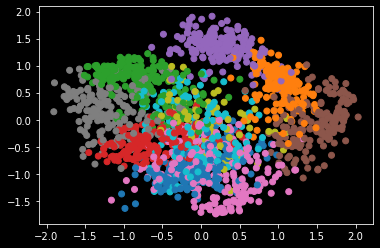

In [19]:
from sklearn.cluster import KMeans

clustering = KMeans(n_clusters=10).fit(digits_norm)

# Visualize Result
cmap = plt.get_cmap('tab10')

plt.scatter(digits_nd[:, 0], digits_nd[:, 1], c=cmap(clustering.labels_))

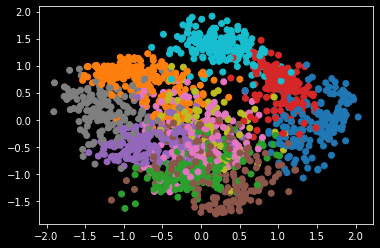

In [20]:
from sklearn.cluster import KMeans

clustering = KMeans(n_clusters=10).fit(digits_nd)

# Visualize Result
cmap = plt.get_cmap('tab10')

plt.scatter(digits_nd[:, 0], digits_nd[:, 1], c=cmap(clustering.labels_))

## Splitting to Train-Test datasets

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(digits_norm, digits.target, test_size=0.2, random_state=42)

## Classifying using Naive Bayes

In [22]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_train, y_train)

GaussianNB()

In [23]:
clf.predict(X_test[:2])

array([6, 9])

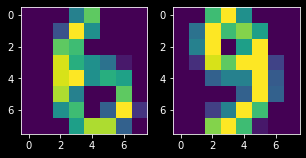

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(5, 10))

ax[0].imshow(np.reshape(X_test[0], (8, 8)))
ax[1].imshow(np.reshape(X_test[1], (8, 8)))

plt.show()

In [25]:
clf.score(X_test, y_test)

0.8333333333333334

## Classifying using MLP (sklearn)

In [26]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=42, max_iter=300, early_stopping=True, n_iter_no_change=5).fit(X_train, y_train)

In [27]:
clf.predict(X_test[4:6])

array([2, 1])

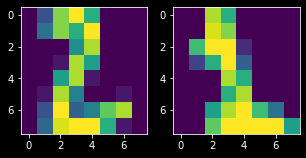

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(5, 10))

ax[0].imshow(np.reshape(X_test[4], (8, 8)))
ax[1].imshow(np.reshape(X_test[5], (8, 8)))

plt.show()

In [29]:
clf.score(X_test, y_test)

0.9527777777777777

## Classifying using Neural Networks (keras)

In [30]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)

print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [31]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                         

2022-04-04 14:50:09.741179: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-04 14:50:09.741441: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [32]:
batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/15


2022-04-04 14:50:12.776286: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


  1/422 [..............................] - ETA: 3:16 - loss: 2.3087 - accuracy: 0.0938

2022-04-04 14:50:13.096395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


420/422 [============================>.] - ETA: 0s - loss: 0.3572 - accuracy: 0.8929

2022-04-04 14:50:18.913115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


422/422 [==============================] - 6s 14ms/step - loss: 0.3564 - accuracy: 0.8931 - val_loss: 0.0839 - val_accuracy: 0.9773
Epoch 2/15
422/422 [==============================] - 6s 14ms/step - loss: 0.1045 - accuracy: 0.9679 - val_loss: 0.0549 - val_accuracy: 0.9855
Epoch 3/15
422/422 [==============================] - 6s 14ms/step - loss: 0.0805 - accuracy: 0.9747 - val_loss: 0.0457 - val_accuracy: 0.9870
Epoch 4/15
422/422 [==============================] - 6s 14ms/step - loss: 0.0657 - accuracy: 0.9796 - val_loss: 0.0426 - val_accuracy: 0.9885
Epoch 5/15
422/422 [==============================] - 6s 14ms/step - loss: 0.0592 - accuracy: 0.9816 - val_loss: 0.0423 - val_accuracy: 0.9890
Epoch 6/15
422/422 [==============================] - 6s 13ms/step - loss: 0.0526 - accuracy: 0.9839 - val_loss: 0.0371 - val_accuracy: 0.9892
Epoch 7/15
422/422 [==============================] - 6s 14ms/step - loss: 0.0493 - accuracy: 0.9845 - val_loss: 0.0359 - val_accuracy: 0.9903
Epoch 8/15

In [33]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.02623692713677883
Test accuracy: 0.9917000532150269


In [34]:
model_out = model.predict(x_test[8:10])

2022-04-04 14:54:13.740952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [35]:
model_out

array([[4.0789783e-07, 3.0623390e-12, 1.0685056e-08, 2.4512735e-08,
        5.6847527e-10, 9.9335736e-01, 5.9075868e-03, 8.5105745e-10,
        7.3139608e-04, 3.2258176e-06],
       [4.8762050e-10, 2.5363878e-12, 9.5572865e-09, 5.0842687e-07,
        3.1076474e-05, 8.0758626e-09, 4.6097461e-14, 3.8364098e-05,
        1.4079029e-04, 9.9978930e-01]], dtype=float32)

In [98]:
np.argmax(model_out, axis=1)

array([5, 9])

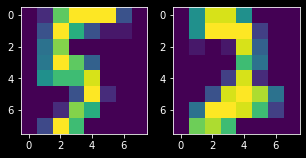

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(5, 10))

ax[0].imshow(np.reshape(X_test[8], (8, 8)))
ax[1].imshow(np.reshape(X_test[9], (8, 8)))

plt.show()

In [37]:
np.argmax(y_test[8:10], axis=1)

array([5, 9])

## New Dataset: Free Spoken Digit Dataset (FSDD - https://github.com/Jakobovski/free-spoken-digit-dataset); Classifying **spoken** digits using Neural Networks (keras)
  * ##### NOTE: Execute ```spectogramer.py``` -- Used for creating spectrograms of the audio data. Spectrograms are often a useful pre-processing step.

In [38]:
import PIL
import os
import tqdm
print('Pillow Version:', PIL.__version__)

Pillow Version: 9.1.0


In [39]:
def get_image_info(dir):
    imname = os.path.basename(dir)
    label = int(imname.split('_')[0])

    image = PIL.Image.open(dir) 
    data = np.asarray(image)

    return imname, data, label


dir_ = os.path.join('..', 'data', 'free-spoken-digit-dataset-master', 'spectrograms')

names, data, labels = [], [], []

for file in tqdm.tqdm(os.listdir(dir_)):
    name, datum, label = get_image_info(os.path.join(dir_, file))
    names.append(name)
    data.append(datum)
    labels.append(label)

names, data, labels = np.array(names), np.array(data), np.array(labels)

100%|██████████| 3000/3000 [00:00<00:00, 3822.00it/s]


In [40]:
names.shape, data.shape, labels.shape

((3000,), (3000, 80, 80, 4), (3000,))

In [41]:
# Split to train/test datasets
names_train, names_test, data_train, data_test, labels_train, labels_test = train_test_split(names, data, labels, test_size=0.2, random_state=42)

In [42]:
# Model / data parameters
num_classes = 10
input_shape = (80, 80, 4)

# Scale images to the [0, 1] range
x_train = data_train.astype("float32") / 255
x_test = data_test.astype("float32") / 255
print("x_train shape:", x_train.shape)

print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(labels_train, num_classes)
y_test = keras.utils.to_categorical(labels_test, num_classes)

x_train shape: (2400, 80, 80, 4)
2400 train samples
600 test samples


In [43]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 78, 78, 32)        1184      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 39, 39, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 18, 18, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 20736)             0         
                                                                 
 dropout_1 (Dropout)         (None, 20736)            

In [44]:
batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/15


2022-04-04 15:01:31.986330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 1s 52ms/step - loss: 2.1273 - accuracy: 0.2532 - val_loss: 1.6673 - val_accuracy: 0.5292
Epoch 2/15
 3/17 [====>.........................] - ETA: 0s - loss: 1.5545 - accuracy: 0.5286

2022-04-04 15:01:32.963990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 1s 38ms/step - loss: 1.2658 - accuracy: 0.5921 - val_loss: 1.1555 - val_accuracy: 0.5625
Epoch 3/15
17/17 [==============================] - 1s 39ms/step - loss: 0.8172 - accuracy: 0.7324 - val_loss: 0.6734 - val_accuracy: 0.8250
Epoch 4/15
17/17 [==============================] - 1s 37ms/step - loss: 0.6027 - accuracy: 0.7995 - val_loss: 0.5200 - val_accuracy: 0.8292
Epoch 5/15
17/17 [==============================] - 1s 37ms/step - loss: 0.4606 - accuracy: 0.8495 - val_loss: 0.5025 - val_accuracy: 0.8542
Epoch 6/15
17/17 [==============================] - 1s 37ms/step - loss: 0.3918 - accuracy: 0.8727 - val_loss: 0.3696 - val_accuracy: 0.8875
Epoch 7/15
17/17 [==============================] - 1s 37ms/step - loss: 0.3323 - accuracy: 0.8917 - val_loss: 0.3219 - val_accuracy: 0.9000
Epoch 8/15
17/17 [==============================] - 1s 37ms/step - loss: 0.2721 - accuracy: 0.9074 - val_loss: 0.2573 - val_accuracy: 0.9292
Epoch 9/15
17/17 [======

In [45]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.19466564059257507
Test accuracy: 0.9366666674613953


In [46]:
# Evaluate model output for a rnadomly selected audio sample from the test set  
idx = 9

name, sample, label = names_test[idx], data_test[idx], labels_test[idx]

print(name, sample.shape, label)

8_nicolas_46.png (80, 80, 4) 8


In [51]:
model.predict(np.expand_dims(sample, 0))

2022-04-04 15:04:57.284059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

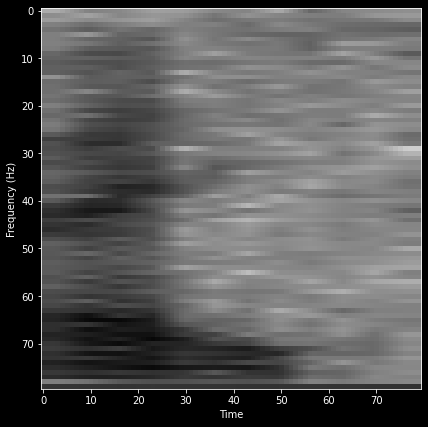

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

ax.imshow(sample, cmap='gray')

ax.set_xlabel('Time')
ax.set_ylabel('Frequency (Hz)')

plt.show()

In [48]:
import IPython

IPython.display.Audio(os.path.join(dir_, '..', 'recordings', f"{name.split('.')[0]}.wav"), autoplay=True)